**Importing Libraries**

In [1]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

**Defining the Model**

In [3]:
def cnn_mobilenet_model_fn(features,labels,mode):
  #Correct dimensions
  input_layer = tf.reshape(features["x"], [-1,28,28,1])  
  #Define Model
  conv1 = tf.layers.separable_conv2d(inputs = input_layer,filters = 32,kernel_size = [5,5],padding = "same",activation = tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
  conv2 = tf.layers.separable_conv2d(inputs = pool1,filters = 64,kernel_size = [5,5],padding = "same",activation = tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
  pool2_flat = tf.reshape(pool2, [-1,7*7*64])
  dense = tf.layers.dense(inputs=pool2_flat, units=128,activation=tf.nn.relu)
  dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
  logits = tf.layers.dense(inputs=dropout,units=10)
  #Predictions
  predictions = {
		"classes":tf.argmax(input=logits,axis=1),
		"probabilities": tf.nn.softmax(logits, name="softmax_tensor")
	}

	#Predict Mode
  if mode == tf.estimator.ModeKeys.PREDICT :
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

	#Loss (eval and train both)
	# One hot labels ? 
	# onehot_labels = tf.one_hot(indices=tf.cast(labels,tf.int32), depth=10)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits) # onehot_labels=onehot_labels

	#Train
  if mode == tf.estimator.ModeKeys.TRAIN :
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(
      loss = loss,
      global_step = tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

	#Eval
  eval_metric_ops = {
    "accuracy" : tf.metrics.accuracy(
      labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

**Loading the dataset**

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


**Visualizing the dataset**

16 Random images and their labels


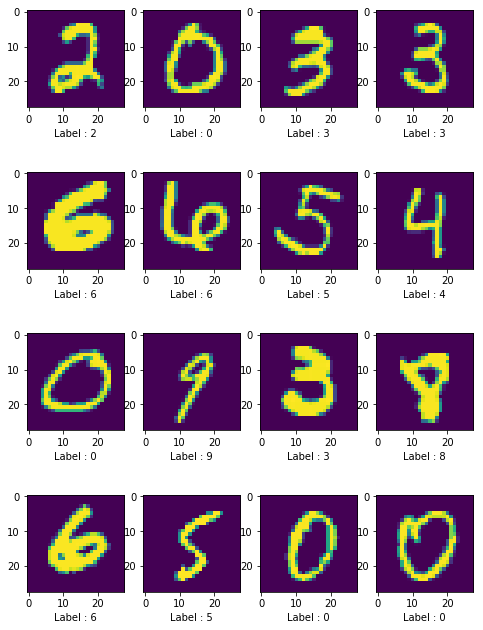

In [6]:
#Preview random image
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(top=1.2)
col = 4
row = 4
print(str(col*row)+" Random images and their labels")
ri = random.sample(range(0,len(train_data)),col*row)
rii = 0
for i in range(1, col*row+1):
  img = np.copy(train_data[ri[rii]])
  img = img.reshape((28,28))
  img = np.asarray(img, dtype=np.float32)
  fig.add_subplot(row,col,i)
  x_label = 'Label : ' + str(train_labels[ri[rii]])
  plt.xlabel(x_label)
  plt.imshow(img, interpolation = 'nearest')
  rii = rii + 1
_ = plt.show()

**Creating an Estimator to train, evaluate and make predictions on the dataset**

In [7]:
mnist_classifier = tf.estimator.Estimator(
model_fn = cnn_mobilenet_model_fn, model_dir = "/tmp/mnist_mobilenet_convnet_modelpr")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_mobilenet_convnet_modelpr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb214b95f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
# Logging predictions
tensors_to_log = {"probabilities" : "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors = tensors_to_log, every_n_iter=500)

**Training**

In [9]:
#Training
train_input_fn = tf.estimator.inputs.numpy_input_fn(
  x = {"x": train_data},
  y=train_labels,
	batch_size=128,
	num_epochs = 10,
	shuffle=True)
mnist_classifier.train(input_fn = train_input_fn, hooks = [logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_mobilenet_convnet_modelpr/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into /tmp/mnist_mobilenet_convnet_modelpr/model.ckpt.
INFO:tensorflow:probabilities = [[0.10255548 0.10230294 0.10014567 ... 0.09642489 0.10047501 0.10020368]
 [0.10119031 0.09889583 0.09981997 ... 0.10018666 0.10158383 0.10021881]
 [0.09981043 0.09860729 0.09812883 ... 0.09662188 0.10435738 0.097401  ]
 ...
 [0.10063373 0.1012784  0.0980255  ... 0.09706748 0.09893417 0.1017568 ]
 [0.10494297 0.0971233  0.09887425 ... 0.09578683 0.10119221 0.10008993]
 [0.10379785 0.09863753 0.1005047  ... 0.09636673 0.09963434 0.10011934]]
INFO:tensorflow:loss = 2.3050508, step = 2
INFO:tensorflow:global_step/sec: 5.76433
INFO:tensorflow:

INFO:tensorflow:loss = 0.18273038, step = 3802 (16.919 sec)
INFO:tensorflow:global_step/sec: 5.62319
INFO:tensorflow:loss = 0.27051556, step = 3902 (17.782 sec)
INFO:tensorflow:global_step/sec: 5.36448
INFO:tensorflow:probabilities = [[0.00000004 0.00000005 0.         ... 0.00004193 0.00000012 0.00045177]
 [0.9999862  0.         0.00000001 ... 0.00000114 0.00000471 0.00000097]
 [0.00000291 0.90528303 0.00187844 ... 0.00000027 0.01201043 0.0000097 ]
 ...
 [0.00000003 0.0000001  0.99947745 ... 0.00027988 0.00016066 0.00000028]
 [0.20940085 0.00001223 0.00009117 ... 0.00014555 0.0230841  0.04177416]
 [0.00000002 0.00000002 0.         ... 0.000002   0.00022425 0.00000073]] (85.453 sec)
INFO:tensorflow:loss = 0.14122239, step = 4002 (18.644 sec)
INFO:tensorflow:global_step/sec: 5.53929
INFO:tensorflow:loss = 0.15843901, step = 4102 (18.051 sec)
INFO:tensorflow:global_step/sec: 5.54601
INFO:tensorflow:loss = 0.13744663, step = 4202 (18.030 sec)
INFO:tensorflow:Saving checkpoints for 4298 int

**Evaluating**

In [10]:
#Eval
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
	x={"x":eval_data},
	y=eval_labels,
	num_epochs=1,
	shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)
print()
print("The accuracy on Test Dataset is : "+str(eval_results["accuracy"]*100) + "% and the loss is : " + str(eval_results["loss"]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-14-14:25:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_mobilenet_convnet_modelpr/model.ckpt-4298
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-14-14:25:08
INFO:tensorflow:Saving dict for global step 4298: accuracy = 0.9651, global_step = 4298, loss = 0.112504125
{'accuracy': 0.9651, 'loss': 0.112504125, 'global_step': 4298}

The accuracy on Test Dataset is : 96.50999903678894% and the loss is : 0.112504125


**Making Predictions on random images from test data**

16 Random images and their labels and predicted class
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_mobilenet_convnet_modelpr/model.ckpt-4298
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


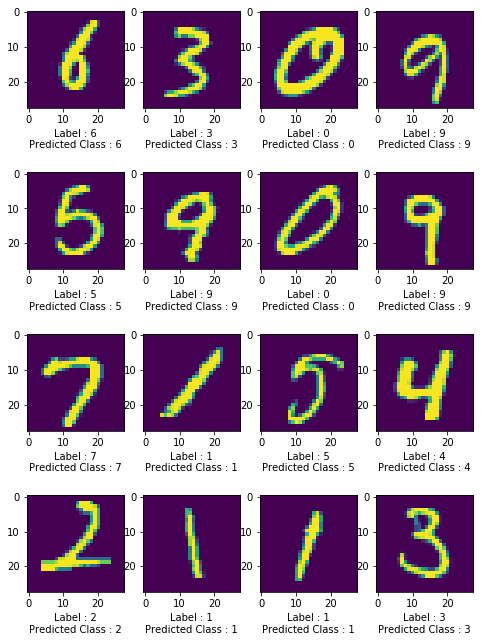

In [11]:
#Preview random image
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(top=1.2)
col = 4
row = 4
print(str(col*row)+" Random images and their labels and predicted class")
#Generating random numbers, these numbers will be the indices of the images chosen
ri = random.sample(range(0,len(eval_data)),col*row)

#predict_x stores images chosen
predict_x = []
for i in ri:
  predict_x.append(np.array(eval_data[i],dtype=np.float32))

#Estimator to predict classes
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x":np.array(predict_x,dtype=np.float32)},shuffle=False)
predictions = mnist_classifier.predict(input_fn = predict_input_fn)
#Storing the classes predicted
predicted_class = []
for pred_dict in predictions:
  predicted_class.append(pred_dict['classes'])

#Plotting
rii = 0
for i in range(1, col*row+1):
  img = np.copy(eval_data[ri[rii]])
  img = img.reshape((28,28))
  img = np.asarray(img, dtype=np.float32)
  fig.add_subplot(row,col,i)
  x_label = 'Label : ' + str(eval_labels[ri[rii]]) + "\n" + "Predicted Class : " + str(predicted_class[rii])
  plt.xlabel(x_label)
  plt.imshow(img, interpolation = 'nearest')
  rii = rii + 1
_ = plt.show()